In [1]:
#using Revise

In [1]:
using Knet

In [2]:
using ImageView;


(julia:36391): Gtk-WARNING **: 09:27:41.603: Theme parsing error: gtk.css:1521:23: 'font-feature-settings' is not a valid property name

(julia:36391): Gtk-WARNING **: 09:27:41.606: Theme parsing error: gtk.css:3460:25: 'font-feature-settings' is not a valid property name

(julia:36391): Gtk-WARNING **: 09:27:41.607: Theme parsing error: gtk.css:3922:23: 'font-feature-settings' is not a valid property name
Gtk-Message: 09:27:41.674: Failed to load module "canberra-gtk-module"
Gtk-Message: 09:27:41.674: Failed to load module "canberra-gtk-module"


In [3]:
include("../helper.jl")
include("mpii.annotation.parser.jl")
include("accuracy.jl")
include("loss.jl")
include("mpii.batcher.jl")
include("../models.jl")
include("../training.jl")
include("../plots.jl")
include("../modular.resnet.jl")

generate_headless_resnet_from_weights (generic function with 1 method)

In [4]:
dtrn, dval = get_mpii_batches(32)

(8-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Float32,N} where N}}, 1-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Float32,N} where N}})

In [5]:
# 5) Implementing a Convolutional Neural Network
simple_conv_net =   Chain(
    ResLayerConv(3, 3, 3, 8; stride=2, padding=1),
    ResLayerConv(3, 3, 8, 16; stride=2, padding=1),
    ResLayerConv(3, 3, 16, 32; stride=2, padding=1),
    Conv2(3, 3, 32, 32),
    ResLayerConv(3, 3, 32, 32; stride=2, padding=1),
    Deconv(3, 3, 14, 32; padding=1),
    loss=sigmoid_cross_entropy_loss
)

Chain((ResLayerConv(P(KnetArray{Float32,4}(3,3,3,8)), 1, 2), ResLayerConv(P(KnetArray{Float32,4}(3,3,8,16)), 1, 2), ResLayerConv(P(KnetArray{Float32,4}(3,3,16,32)), 1, 2), Conv2(P(KnetArray{Float32,4}(3,3,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), Knet.Ops20.relu), ResLayerConv(P(KnetArray{Float32,4}(3,3,32,32)), 1, 2), Deconv(P(KnetArray{Float32,4}(3,3,14,32)), 1, 1)), 0, 0, sigmoid_cross_entropy_loss)

In [8]:
simple_conv_net_results = trainresults("simple_conv_net.jld2", simple_conv_net, dtrn, dval, 100, 0.15; accuracy_func=modelized_naive_pck_sigm, error_func=nothing);

┣████████████████████┫ [100.00%, 800/800, 00:10/00:10, 77.23i/s] 


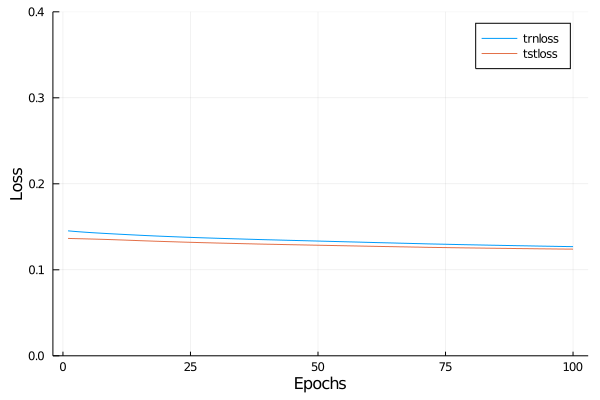

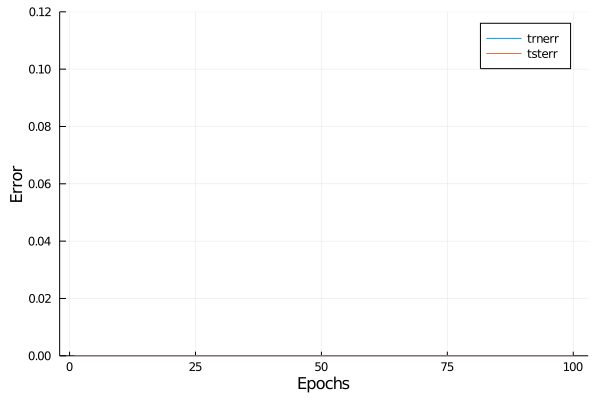

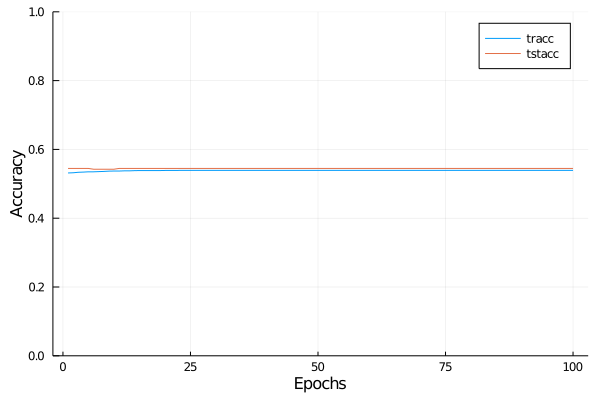

In [9]:
draw_plots(simple_conv_net_results)

In [12]:
dtrn_x1, dtrn_y1 = first(dtrn)
dval_x1, dval_y1 = first(dval)

(K32(128,128,3,32)[0.94509804⋯], K32(4,4,71,32)[0.0⋯])

In [10]:
simple_conv_net(dval)

0.1240225f0

In [13]:
sigmoided_output = Array(sigm.(simple_conv_net(dval_x1)));

In [15]:
total_pck = naive_pck(sigmoided_output, dval_y1);
println(total_pck)

54.464285714285715


In [16]:
function get_params(params, atype)
    len = length(params["value"])
    ws, ms = [], []
    for k = 1:len
        name = params["name"][k]
        value = convert(Array{Float32}, params["value"][k])

        if endswith(name, "moments")
            push!(ms, reshape(value[:,1], (1,1,size(value,1),1)))
            push!(ms, reshape(value[:,2], (1,1,size(value,1),1)))
        elseif startswith(name, "bn")
            push!(ws, reshape(value, (1,1,length(value),1)))
        elseif startswith(name, "fc") && endswith(name, "filter")
            push!(ws, transpose(reshape(value,(size(value,3),size(value,4)))))
        elseif startswith(name, "conv") && endswith(name, "bias")
            push!(ws, reshape(value, (1,1,length(value),1)))
        else
            push!(ws, value)
        end
    end
    map(wi->convert(atype, wi), ws),
    map(mi->convert(atype, mi), ms)
end

get_params (generic function with 1 method)

In [17]:
model_file_path = "/home/gsoykan/Desktop/comp541/comp541_term_project/results/imagenet-resnet-152-dag.mat"

o = Dict(
  :atype => KnetArray{Float32},
  :model => model_file_path,
  :top   => 10
)
model = matread(abspath(o[:model]))
w, ms = get_params(model["params"], o[:atype]);

In [18]:
modular_resnet152 = generate_headless_resnet_from_weights(w, ms);

In [41]:
w[2:3]

2-element Array{KnetArray{Float32,N} where N,1}:
 K32(1,1,64,1)[0.17125425⋯]
 K32(1,1,64,1)[-0.9211457⋯]

In [37]:
res_mean = ms[1]
res_variance = ms[2]



1×1×64×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.005939396

[:, :, 2, 1] =
 61.043705

[:, :, 3, 1] =
 28.928087

...

[:, :, 62, 1] =
 59.977142

[:, :, 63, 1] =
 111.452835

[:, :, 64, 1] =
 104.22023

In [38]:
bnmoments(meaninit=res_mean, varinit=res_variance)

Knet.Ops20.BNMoments(0.1, nothing, nothing, K32(1,1,64,1)[-9.028228e-5⋯], K32(1,1,64,1)[0.005939396⋯])

In [39]:
bnmoments()

Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones)

In [42]:
bnparams(w[2:3])

LoadError: MethodError: no method matching bnparams(::Array{KnetArray{Float32,N} where N,1})
Closest candidates are:
  bnparams(::Any, !Matched::Integer) at /home/gsoykan/.julia/packages/Knet/LdQyF/src/ops20/batchnorm.jl:117
  bnparams(!Matched::Integer) at /home/gsoykan/.julia/packages/Knet/LdQyF/src/ops20/batchnorm.jl:124

In [19]:
resnet_with_deconv = Chain(modular_resnet152.layers...,  
    Deconv(3, 3, 14, 2048; padding=1); loss=sigmoid_cross_entropy_loss);

In [20]:
resnet_output = Array(sigm.(resnet_with_deconv(dtrn_x1)))

4×4×14×32 Array{Float32,4}:
[:, :, 1, 1] =
 0.775838   0.879748    0.766073   0.733447
 0.456233   0.888043    0.474407   0.748521
 0.261607   0.285471    0.472772   0.952023
 0.0294814  0.00172515  0.0326735  0.834397

[:, :, 2, 1] =
 0.0439027  0.0528852   0.194036   0.226963
 0.118319   0.287597    0.201373   0.45042
 0.0866285  0.00925973  0.041448   0.46474
 0.205048   0.047127    0.0156239  0.123632

[:, :, 3, 1] =
 0.529578   0.430938   0.299538  0.189498
 0.15216    0.15518    0.185473  0.225548
 0.0508886  0.0465453  0.158548  0.0614671
 0.0308145  0.0454913  0.30282   0.538673

...

[:, :, 12, 1] =
 0.666614  0.913985  0.963341  0.863565
 0.302472  0.4509    0.511356  0.800197
 0.293347  0.848518  0.615719  0.757973
 0.833877  0.996989  0.982742  0.938116

[:, :, 13, 1] =
 0.763152  0.920593  0.433287  0.628569
 0.991043  0.99725   0.963309  0.990164
 0.986469  0.994332  0.994107  0.967407
 0.908978  0.986974  0.933979  0.892841

[:, :, 14, 1] =
 0.221382  0.571151  0.760678 

In [21]:
total_pck_resnet = naive_pck(resnet_output, dtrn_y1);
println(total_pck_resnet)

6.25


In [22]:
resnet_with_deconv(dtrn)

1.4470946f0

In [23]:
CUDA.reclaim()

4896678912

In [26]:
CUDA.memory_status() 

Effective GPU memory usage: 23.22% (1.378 GiB/5.935 GiB)
CUDA allocator usage: 496.372 MiB
binned usage: 138.398 MiB (23.281 KiB allocated, 138.375 MiB cached)
Discrepancy of 357.974 MiB between memory pool and allocator!


In [25]:
GC.gc(true)

In [1129]:
# TODO: Fix batch norm issue here try with different batchnorms
# Check here https://github.com/denizyuret/Knet.jl/blob/master/examples/dcgan-mnist/dcgan.jl
# and
# check previous batch norm emails

resnetnet_results = trainresults("resnet_with_deconv.jld2", resnet_with_deconv, dtrn, dval, 100, 0.15; accuracy_func=nothing, error_func=nothing);


Stacktrace:
 [1] vbroadcast_shape(::KnetArray{Float32,4}, ::KnetArray{Float32,4}) at /home/gsoykan/.julia/packages/Knet/LdQyF/src/knetarrays/binary.jl:172
 [2] broadcasted(::typeof(-), ::KnetArray{Float32,4}, ::KnetArray{Float32,4}) at /home/gsoykan/.julia/packages/Knet/LdQyF/src/knetarrays/binary.jl:46
 [3] forw(::Function, ::Function, ::Vararg{Any,N} where N; kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at /home/gsoykan/.julia/packages/AutoGrad/VFrAv/src/core.jl:66
 [4] forw at /home/gsoykan/.julia/packages/AutoGrad/VFrAv/src/core.jl:65 [inlined]
 [5] broadcasted at ./none:0 [inlined]
 [6] batchnorm_as_function(::Array{KnetArray{Float32,N} where N,1}, ::AutoGrad.Result{KnetArray{Float32,4}}, ::Array{KnetArray{Float32,4},1}; training::Bool, epsilon::Float64) at /home/gsoykan/Desktop/comp541/comp541_term_project/utils.jl:61
 [7] batchnorm_as_function(::Array{KnetArray{Float32,N} where N,1}, ::AutoGrad.Result{KnetArray{Float32,4}}, ::Array{KnetArray{Flo

LoadError: DimensionMismatch("arrays could not be broadcast to a common size")

In [1142]:
sigmoided_output = Array(sigm.(simple_conv_net(dtrn_x1)));

In [1238]:
function draw_first_images_forehead(y)
test_y = y[:, :, :, 17];
colorview(Gray, test_y[:, : , 2])
end

draw_first_images_forehead (generic function with 1 method)

In [1209]:
#Array(dtrn_y1)

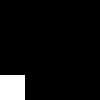

In [1239]:
draw_first_images_forehead(Array(dtrn_y1))

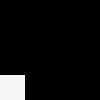

In [1240]:
draw_first_images_forehead(sigmoided_output)

In [724]:
#draw_plots(simple_conv_net_results);

In [1230]:
test_image = Array(dtrn_x1)[:, :, :, 17];

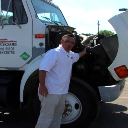

In [1231]:
perm = permutedims(test_image, [3, 1, 2])
colorview(RGB, perm)
#colorview(RGB, rand(3,256,256))


In [235]:
size(ytrn)

(16, 16, 71, 64)

In [240]:
first(dtrn)[1] |> size

(128, 128, 3, 64)

In [241]:
first(dtrn)[2] |> size

(16, 16, 71, 64)

In [434]:
#julia> w0 = KnetArray(randn(Float32, 5, 5, 1, 20));

#julia> x0 = KnetArray(rand(Float32, 24, 24, 20, 100));

#julia> size(deconv4(w0,x0)) # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)
#

w0 = KnetArray(randn(Float32, 5, 5, 1, 20));
 x0 = KnetArray(rand(Float32, 24, 24, 20, 100));

 # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)

In [435]:
size(deconv4(w0,x0))

(26, 26, 1, 100)

In [244]:
tc = Conv2(3, 3, 3, 3)

Conv2(P(KnetArray{Float32,4}(3,3,3,3)), P(KnetArray{Float32,4}(1,1,3,1)), Knet.Ops20.relu)

In [392]:
fb = first(dtrn)[1];

In [393]:
res_tc = tc2(fb) |> tc;

In [437]:
mid = res_tc |> tc2

16×16×3×64 KnetArray{Float32,4}:
[:, :, 1, 1] =
  0.112997    0.0517907  0.0520545  0.0519588  …   0.0475755    0.0123551
  0.00921452  0.0132281  0.0129419  0.0123628      0.0150117   -0.0227738
  0.00826144  0.0145944  0.0121391  0.013257       0.0130657   -0.0205809
  0.0134121   0.0111661  0.0140461  0.0135455      0.0137847   -0.0215094
  0.01818     0.0129529  0.0131644  0.0133484      0.0142651   -0.0205225
  0.0140348   0.0133471  0.0134129  0.013993   …   0.0133054   -0.0204491
  0.0140647   0.0126312  0.0138596  0.0136938     -0.00172006  -0.0240447
  0.0125345   0.012157   0.0134645  0.0132168     -0.00509805  -0.0628166
  0.0131149   0.014411   0.0125145  0.0153247      0.052321     0.198369
  0.0142692   0.0131414  0.0128014  0.0122287      0.0531236   -0.000250595
  0.015522    0.0135363  0.0143546  0.0112565  …   0.0304594   -0.0201726
  0.0133763   0.0122032  0.0147571  0.0148027      0.0613541   -0.0199047
  0.0151913   0.0118998  0.0121954  0.0119745      0.013699    

In [439]:
w1 = KnetArray(randn(Float32, 3,3, 1, 3));

In [443]:
#deconv4(w1, mid)
size(deconv4(w1, mid; padding=1))

(16, 16, 1, 64)

In [249]:
tc2 = ResLayerConv(3, 3, 3, 3; stride=2, padding=1)

ResLayerConv(P(KnetArray{Float32,4}(3,3,3,3)), 1, 2)

In [264]:
res_tc2 = res_tc |> tc2;

In [265]:
size(res_tc)

(14, 14, 3, 64)

In [267]:
tc2(fb) |> tc2 |> tc2;